# Introducción

<!-- PELICAN_BEGIN_SUMMARY -->

Hace varias semanas salió un [proyecto muy interesante](https://github.com/mm-mansour/Fast-Pandas) en el que se compara la performance  de `Pandas` con `NumPy`. Bien, dado que uso `Pandas` y `NumPy` a diario no me costó demasiado encontrar algunas cosas (quizá algo difusas) que estarían bien comentar o matizar. Sobre todo cuando vemos comparaciones de este estilo, ya que nos podemos quedar con alguna que otra idea errónea.

A continuación voy a tratar de explicar cómo funciona `Pandas` y `NumPy` cuando hacemos llamadas del estilo:

    In [0]: d = pd.DataFrame(...)
    In [1]: d.sum()
    In [2]: np.sum(d)

De hecho, aunque nos pueda parecer trivial, cuando buscamos la máxima performance hacerlo de una u otra forma toma especial relevancia. Como podéis intuir, no es lo mismo hacer `d.sum()` que `np.sum(d)`. Otro apunte intersante, para los que no lo sabéis, los cálculos en `Pandas` se apoyan en `NumPy`, pero también en [`bottleneck`](https://github.com/kwgoodman/bottleneck) (y en el futuro quizá otras librerías), por ese motivo lo incluyo en esta comparativa, lo veremos con más detalle.

<!-- PELICAN_END_SUMMARY -->

In [1]:
# Dependencias
# !pip install git+https://github.com/mmngreco/timer_plus.git
# !pip install watermark
# !pip install bottleneck

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import bottleneck as bn
import timer_plus as tp

## Descripción del entorno y SO

Esto siempre es un factor a tener en cuenta cuando se habla de performance.

In [3]:
%load_ext watermark

In [4]:
%watermark -v -m -p numpy,scipy,pandas,bottleneck,numexpr

CPython 3.6.4
IPython 6.2.1

numpy 1.14.1
scipy 1.0.0
pandas 0.22.0
bottleneck 1.2.1
numexpr 2.6.4

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [5]:
def get_data(constructor, shape, dtype):
    arr = np.random.randint(0, 1000, shape).astype(dtype)
    return constructor(arr)

def timeit_results(name, stmt, data_name, repeats, globs):
    """Calcula el tiempo de un statement.
    
    Parameters
    ----------
    name : str
        Nombre que se le quiere dar al statement.
    stmt : str
        Statement que se ejecutará.
    data_name : str
        Nombre de la variable que se usa como input en el 
        stmt.
    repeats : int
        Número de repeticiones que se ejecutará el stmt.
    globs : dict
        Diccionario con todas la variables necesarias para 
        que el stmt se pueda ejecutar.
    
    Returns
    -------
    time_results : pandas.DataFrame
        Devuelve un pandas.DataFrame en formato long table 
        con columnas: time, stmt, N, name. La longitud será
        igual a `repeats`.
    """
    tmr = tp.Timer(stmt, globals=globs).repeat_autorange(repeats)
    res = pd.DataFrame(tmr, columns=['time'])
    res['stmt'] = stmt
    res['N'] = "{:.0e}".format(globs[data_name].shape[0]).replace('e+0', '0^')
    res['name'] = name
    return res

# Calculando tiempos

En esta parte voy a construir un `DataFrame` en el que se guardan los tiempos (,nombre, statement, N) de ejecución de las siguiente llamadas:

    >>> pandas_stmt = "d.sum()"
    >>> numpy_stmt = "np.nansum(d)"
    >>> pure_numpy_stmt = "pd.Series(np.nansum(d.values), index=d.columns)"
    >>> bottleneck_stmt = "pd.Series(bn.nansum(d.values), index=d.columns)"

Estas llamadas se explican con más detalle más abajo, de momento vamos a quedarnos con que son algunas de las posibles alternativas para calcular la `sum` de un `DataFrame` y que nos __devuelve el mismo objeto__ en los 4 casos.

Para realizar la comparación de tiempos he usado la función `timeit_results` definida arriba, esta función usa un mini proyecto para poder hacer este tipo de comparaciones de forma más cómoda.


In [6]:
# CALCULO DE TIEMPOS
# ==================

# Definimos las longitudes como potencias de 10 hasta 10^8
N_list = np.power(10, np.arange(1, 9))
repeats = 30
dtype = np.int64
data = get_data(pd.DataFrame, (max(N_list),1), dtype)

# Statements
pandas_stmt = "d.sum()"
numpy_stmt = "np.sum(d)"
pure_numpy_stmt = "pd.Series(np.nansum(d.values), index=d.columns)"
bottleneck_stmt = "pd.Series(bn.nansum(d.values), index=d.columns)"

# Variables usadas en los statements
globs = {"d": data, "np": np, "pd": pd, "data": data, "bn": bn}

results = []
for N in N_list:
    globs['d'] = data[:N:]
    results += [timeit_results('pandas', pandas_stmt, 'd', repeats, globs)]
    results += [timeit_results('numpy', numpy_stmt, 'd', repeats, globs)]
    results += [timeit_results('pure_numpy', pure_numpy_stmt, 'd', repeats, globs)]
    results += [timeit_results('botleneck', bottleneck_stmt, 'd', repeats, globs)]

pd_results = pd.concat(results)

Los statements (`stmt`) los he escrito de tal forma que devuelvan el mismo objeto, un `pandas.Series` en este caso dado que es lo que devuelve `d.sum()`. De esta forma nos aseguramos de que el usuario de `pandas` tiene como resultado el mismo objeto y los tiempos son comparables entre sí.

In [7]:
pd_results.head()

,time,stmt,N,name
0,0.000266,d.sum(),10^1,pandas
1,0.000208,d.sum(),10^1,pandas
2,0.000209,d.sum(),10^1,pandas
3,0.000206,d.sum(),10^1,pandas
4,0.000198,d.sum(),10^1,pandas


Donde:

- *time* es el tiempo medio en segundos. 
- *stmt* es la línea de código que se ejecutará. 
- *N* es la longitud de los datos.
- *name* es un alias más amigable del statement. 

## Resultados

Con el `DataFrame` en [long form](https://medium.com/@andykashyap/how-to-convert-a-table-into-long-form-or-tidy-form-for-seaborn-visualizations-2bd8b44cdc29) anterior voy a construir una tabla resumen de los tiempos medios y desviación típica para cada longitud del `DataFrame` pasado como input y un nombre (no es mas que un alias del `statement`).

In [8]:
def mu_std(x):
    """Imprime la media (std).
    
    Sólo funciona en python36
    
    Parameters
    ----------
    x : array-like
    
    Returns
    -------
    mu_std : str
    """
    mu = np.mean(x)
    std = np.std(x)
    return f"{mu:.6f} ({std:.6f})"

In [9]:
pd_results.pivot_table(index='N', values='time', columns=['name'], aggfunc=mu_std)

name,botleneck,numpy,pandas,pure_numpy
N,,,,
10^1,0.000094 (0.000003),0.000208 (0.000009),0.000203 (0.000014),0.000109 (0.000005)
10^2,0.000096 (0.000005),0.000227 (0.000036),0.000195 (0.000006),0.000112 (0.000005)
10^3,0.000096 (0.000004),0.000219 (0.000010),0.000206 (0.000010),0.000112 (0.000006)
10^4,0.000107 (0.000004),0.000262 (0.000008),0.000244 (0.000009),0.000141 (0.000015)
10^5,0.000167 (0.000007),0.000693 (0.000013),0.000677 (0.000015),0.000273 (0.000007)
10^6,0.001121 (0.000047),0.008130 (0.000179),0.008092 (0.000125),0.004545 (0.000105)
10^7,0.008969 (0.000172),0.075049 (0.001520),0.080686 (0.027643),0.045551 (0.001036)
10^8,0.084068 (0.001555),1.227781 (0.067859),1.463971 (0.755026),0.893592 (0.021614)


> _Tabla 1: Tiempos por statement y longitud del DataFrame._

La tabla muestra la media de los tiempos en segundos de cada statement. Entre paréntesis se encuentran las desviaciones típicas. Dado que una imagen vale más que mil palabras, que hable `seaborn`:

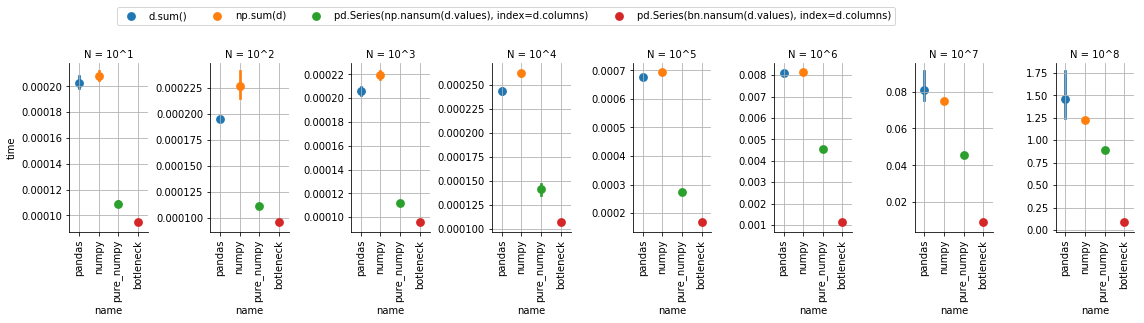

In [10]:
g = sns.factorplot(x='name', y='time', data=pd_results, hue='stmt', size=4, col='N', sharey=False, sharex=False, aspect=0.5, kind='point', legend=False)
for ax in g.axes.flat:
    labels = ax.get_xticklabels()
    for l in labels:
        l.update(dict(rotation=90))
    ax.grid(True)
plt.legend(bbox_to_anchor=(0.1,1.03), loc="lower left", bbox_transform=g.fig.transFigure, ncol=4)
g.fig.tight_layout()

> _Gráfico 1: Scatter de la media de los tiempos de ejecución por statement y tamaño del DataFrame._

> Nota: Recordemos que `d` es un `pandas.DataFrame`. 

El gráfico 1 muestra en el eje de las abscisas los nombres de los statements y en el eje de las ordenadas los tiempos en segundos. Los gráficos están separados por tamaño del `DataFrame`, esto es debido a que hay mucha diferencia entre los tiempos en los extremos de N, y si los pintamos en un mismo gráfico no podríamos apreciar los detalles de cada caso.

Lo primero que resalta del gráfico 1 son los tiempos de los casos llamados _pandas_ y _numpy_, los cuales contrastan con los *pure_numpy* y _bottleneck_. Si vamos un poco más al detalle, _numpy_ (con el statement `np.nansum(d)`), es más lenta que la versión _pandas_, `d.sum()`, sin embargo, _numpy_ va alcanzando a _pandas_ a medida que aumenta N, hasta el punto en el que se invierten las posiciones, esto ocurre a partir del tamaño N=10^6, esto sólo es en media. Los tiempos varían mucho más en el caso _pandas_, y se aprecia en las barras de error que se aprecian claramente para los tamaños grandes.

Por otra parte, las implementaciones *pure_numpy* y _bottleneck_ se encuentran en las primeras posiciones del ranking de performance, que son con diferencia mucho más rápidas que las anteriores. La pega está en que las implementaciones no son tan "high level" como las otras, tenemos que acceder al `values`, llamar a la función correspondiente en `numpy`/`bottleneck` y luego envolverlo todo en `Pandas`. Es curioso como el caso *pure_numpy* se aleja de _bottleneck_ a medida que aumenta N, especialmente notorio a partir de N=10^5.

Fijaos que claro, en `Pandas` son muy listos al usar `Bottleneck` siempre que sea posible, porque al final la "lucha" está entre `NumPy` y `Bottleneck`.

# Interpretando los statements:

In [11]:
import inspect

def print_code(func, no_lines=None):
    """Imprime el código de la función o modulo.
    
    Parameters
    ----------
    func : function or module
    no_lines : list
        Una lista de enteros.
    
    Returns
    -------
    None
    """
    print('file:',inspect.getfile(func))
    lines = inspect.getsourcelines(func)
    for i, line in enumerate(lines[0]):
        if no_lines is not None:
            if i not in no_lines:
                continue
        print(i, '\t', line.strip('\n'))

## Caso Pandas

La lógica de `Pandas` es más complicada, y no es tan inmediato de ver en el código como en el caso de `NumPy` (explicado en el siguiente apartado). Lo podríamos resumir en lo siguiente:

    >>> d = pd.DataFrame(...)
    >>> d.sum()  -->  np.nansum(d.values) --> d.values.sum()
                 ^^^
    Pandas llama a numpy.nansum (o bottleneck.nansum) en nanops.py

Cuando invocamos al método `.sum()` de `Pandas`, por defecto, tanto las `Series` como los `DataFrames`, usan la función `nanops.nansum` de `Pandas` que heredan de la clase `NDFrame`:

In [12]:
print_code(pd.core.generic, [97,6990, 6991, 6992, 6993])

file: /Users/mmngreco/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py
97 	 class NDFrame(PandasObject, SelectionMixin):
6990 	         cls.sum = _make_min_count_stat_function(
6991 	             cls, 'sum', name, name2, axis_descr,
6992 	             'Return the sum of the values for the requested axis',
6993 	             nanops.nansum, _sum_examples)


Arriba puede verse que en la clase `NDFrame` se define el método `sum` como un alias de `nanops.nansum` en la última línea y `nanops.nansum` hace lo siguiente:

In [13]:
print_code(pd.core.nanops.nansum)

file: /Users/mmngreco/miniconda3/lib/python3.6/site-packages/pandas/core/nanops.py
0 	 @disallow('M8')
1 	 @bottleneck_switch()
2 	 def nansum(values, axis=None, skipna=True, min_count=0):
3 	     values, mask, dtype, dtype_max = _get_values(values, skipna, 0)
4 	     dtype_sum = dtype_max
5 	     if is_float_dtype(dtype):
6 	         dtype_sum = dtype
7 	     elif is_timedelta64_dtype(dtype):
8 	         dtype_sum = np.float64
9 	     the_sum = values.sum(axis, dtype=dtype_sum)
10 	     the_sum = _maybe_null_out(the_sum, axis, mask, min_count=min_count)
11 	 
12 	     return _wrap_results(the_sum, dtype)


Lo que hace esta función, `pandas.core.nanops.nansum`, es comprobar si es posible usar `bottleneck` (ver decorador línea 1) y si no, llama al método `sum` de `values`, es decir, llama a `numpy.nansum` (ver línea 9) (ver línea 6993 de `pandas.core.generic`) y nos devuelve el resultado.

## Caso numpy

    numpy_stmt : np.sum(d)

¿Qué hace `numpy` en este caso? Veamos el código:


In [14]:
print_code(np.sum, no_lines=[0, *range(87,105)])

file: /Users/mmngreco/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py
0 	 def sum(a, axis=None, dtype=None, out=None, keepdims=np._NoValue):
87 	     kwargs = {}
88 	     if keepdims is not np._NoValue:
89 	         kwargs['keepdims'] = keepdims
90 	     if isinstance(a, _gentype):
91 	         res = _sum_(a)
92 	         if out is not None:
93 	             out[...] = res
94 	             return out
95 	         return res
96 	     if type(a) is not mu.ndarray:
97 	         try:
98 	             sum = a.sum
99 	         except AttributeError:
100 	             pass
101 	         else:
102 	             return sum(axis=axis, dtype=dtype, out=out, **kwargs)
103 	     return _methods._sum(a, axis=axis, dtype=dtype,
104 	                          out=out, **kwargs)


Aquí la clave está en las líneas 96-98: primero `numpy.sum` comprueba si el objeto que ha recibido NO ES un `ndarray` (línea 96), si no lo es,  intenta acceder al método `.sum()` del objeto. En nuestro caso, el objeto es un `pandas.DataFrame` y por tanto entra en el condicional (no es un `ndarray`) y llama al `d.sum()` que tenga implementado `Pandas`. 

El esquema sería algo como lo siguiente:

    >>> d = pd.DataFrame(...)
    >>> np.sum(d) --> d.sum() --> np.nansum(d.values) --> d.values._sum()


## Caso pure_numpy

    pure_numpy_stmt : pd.Series(np.nansum(d.values), index=d.columns)

El caso pure_numpy es lo que se llamaría _"ir al grano"_. En este caso sabemos lo que hacen las librerías y se lo ponemos fácil:
    
    >>> d = pd.DataFrame
    >>> pd.Series(
            np.nansum(d.values),   # en numpy directamente
            index=d.columns
            )


## Caso bottleneck

    bottleneck_stmt : pd.Series(bn.nansum(d.values), index=d.columns)

Este paso ahorra muchas llamadas intermedias si `Pandas` puede usar `Bottleneck`.

    >>> d = pd.DataFrame
    >>> pd.Series(
            bn.nansum(d.values),  # en bottleneck directamente
            index=d.columns
            )
            

> Nota: Dado que sabemos que no tenemos `NaNs` podríamos ir un paso más allá y aplicar la `np.sum`, pero estaríamos siendo injustos con `Pandas`.

> Nota 2: En el caso de la suma, `Pandas` no usa `Bottleneck` (más detalles en el siguiente apartado).

# El papel de `Bottleneck` en `Pandas`

Como hemos comentado antes, `Pandas` usa para algunos cálculos `Bottleneck` en lugar de `NumPy`, esto es debido a que `bottleneck` tiene un conjunto de funciones que gestionan `NaNs` implementadas en C, lo cual le dota de una gran velocidad de cálculo. Las funciones que tratan hacer uso de `Bottleneck` son las siguientes:

- `mean`
- `median`
- `std`
- `var`
- `min`
- `max`

Esto lo podemos ver en `pandas.core.nanops`, todas la funciones que usan el decorador `@bottleneck_switch` intentarán usar `Bottleneck` para realizar la operación.

Si tenéis curiosidad por este decorador os lo dejo por aquí:

In [15]:
print_code(pd.core.nanops, [89,*range(118,144)])

file: /Users/mmngreco/miniconda3/lib/python3.6/site-packages/pandas/core/nanops.py
89 	 class bottleneck_switch(object):
118 	                 if (_USE_BOTTLENECK and skipna and
119 	                         _bn_ok_dtype(values.dtype, bn_name)):
120 	                     result = bn_func(values, axis=axis, **kwds)
121 	 
122 	                     # prefer to treat inf/-inf as NA, but must compute the func
123 	                     # twice :(
124 	                     if _has_infs(result):
125 	                         result = alt(values, axis=axis, skipna=skipna, **kwds)
126 	                 else:
127 	                     result = alt(values, axis=axis, skipna=skipna, **kwds)
128 	             except Exception:
129 	                 try:
130 	                     result = alt(values, axis=axis, skipna=skipna, **kwds)
131 	                 except ValueError as e:
132 	                     # we want to transform an object array
133 	                     # ValueError message to the mor

Ahora ya sabéis qué ocurre en `Pandas` y `NumPy` por debajo cuando se hacen las llamadas que hemos visto. `Pandas`, a medida que aumenta el tamaño de los datos, se vuelve más eficiente, sin embargo, en ningún caso, gana a una implementación "ad hoc" como las *pure_numpy* o *bottleneck*. Siempre se puede atajar, pero `Pandas` lo hace muy bien en general, no nos tenemos que preocupar de si lo que devuelve es una `Serie`, `DataFrame`, `array`, `int`, `float`, etc, nos devuelve lo que tiene que ser, y por si fuera poco sin preocuparnos por los índices, columnas, nombres, dtypes... si lo miramos todo en conjunto no está nada mal.

That's all folks!